In [1]:
!unzip gazprom.zip
!unzip invest.zip
!unzip lottery.zip
!unzip mail.zip
!unzip not_phishy.zip
!unzip vk.zip
!unzip votes.zip
%ls

Archive:  gazprom.zip
   creating: gazprom/
  inflating: gazprom/000009.png      
  inflating: gazprom/000030.png      
  inflating: gazprom/000031.png      
  inflating: gazprom/000070.png      
  inflating: gazprom/000073.png      
  inflating: gazprom/000077.png      
  inflating: gazprom/000091.png      
  inflating: gazprom/000115.png      
  inflating: gazprom/000118.png      
  inflating: gazprom/000120.png      
  inflating: gazprom/000122.png      
  inflating: gazprom/000124.png      
  inflating: gazprom/000128.png      
  inflating: gazprom/000134.png      
  inflating: gazprom/000136.png      
 extracting: gazprom/000141.png      
  inflating: gazprom/000177.png      
  inflating: gazprom/000186.png      
  inflating: gazprom/000189.png      
 extracting: gazprom/000221.png      
  inflating: gazprom/000222.png      
  inflating: gazprom/000224.png      
  inflating: gazprom/000226.png      
  inflating: gazprom/000237.png      
  inflating: gazprom/000244.png      
  infl

In [2]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
from collections import defaultdict

In [51]:
def load_models():
    models = {
        "clip_large": CLIPModel.from_pretrained("openai/clip-vit-large-patch14"),
        "clip_base": CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    }
    processors = {
        "clip_large": CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14"),
        "clip_base": CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    }
    return models, processors

In [52]:
def classify_image(image_path, model, processor):
    image = Image.open(image_path).convert("RGB")
    texts = [
        "Обычное изображение",
        "Фишинг: фальшивый QR-код",
        "Фишинг: голосования",
        "Фишинг: поддельная страница входа в соцсети",
        "Фишинг: предложение банковских услуг или биржи",
    ]

    inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image.softmax(dim=1)

    phishing_prob = logits_per_image[0, 1].item() * 10
    return phishing_prob

In [53]:
def classify_dataset(dataset_path, model, processor):
    results = {}
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                confidence = classify_image(image_path, model, processor)
                results[image_path] = confidence
                print(f"{image_path}: Уверенность фишинга {confidence:.1f} из 10")
    return results

In [54]:
def evaluate_accuracy(results, phishing_folders, not_phishy_folder):
    folder_accuracies = {}

    for folder in phishing_folders + [not_phishy_folder]:
        folder_results = {path: score for path, score in results.items() if folder in path}
        true_positives = sum(1 for path, score in folder_results.items() if folder in phishing_folders and score > 5)
        false_negatives = sum(1 for path, score in folder_results.items() if folder in phishing_folders and score <= 5)
        true_negatives = sum(1 for path, score in folder_results.items() if folder == not_phishy_folder and score <= 5)
        false_positives = sum(1 for path, score in folder_results.items() if folder == not_phishy_folder and score > 5)

        total = true_positives + false_negatives + true_negatives + false_positives
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        folder_accuracies[folder] = accuracy
        print(f"Точность для папки {folder}: {accuracy:.2%}")

    return folder_accuracies

In [55]:
models, processors = load_models()

In [56]:
phishing_folders = [ "invest", "lottery", "mail", "vk", "votes"]
not_phishy_folder = "not_phishy"

In [57]:
all_results = defaultdict(dict)

In [58]:
for model_name, model in models.items():
  print(f"Классификация с моделью {model_name}:")
  processor = processors[model_name]
  results = classify_dataset(".", model, processor)
  all_results[model_name] = results
  evaluate_accuracy(results, phishing_folders, not_phishy_folder)

Классификация с моделью clip_large:
./votes/000005.png: Уверенность фишинга 1.0 из 10
./votes/000032.png: Уверенность фишинга 10.0 из 10
./votes/000197.png: Уверенность фишинга 3.4 из 10
./votes/000067.png: Уверенность фишинга 10.0 из 10
./votes/000131.png: Уверенность фишинга 3.6 из 10
./votes/000096.png: Уверенность фишинга 8.1 из 10
./votes/000011.png: Уверенность фишинга 8.4 из 10
./votes/000236.png: Уверенность фишинга 8.6 из 10
./votes/000159.png: Уверенность фишинга 3.1 из 10
./votes/000099.png: Уверенность фишинга 7.4 из 10
./votes/000092.png: Уверенность фишинга 3.5 из 10
./votes/000212.png: Уверенность фишинга 1.2 из 10
./votes/000034.png: Уверенность фишинга 7.0 из 10
./votes/000004.png: Уверенность фишинга 1.3 из 10
./votes/000053.png: Уверенность фишинга 4.0 из 10
./votes/000017.png: Уверенность фишинга 7.4 из 10
./votes/000018.png: Уверенность фишинга 10.0 из 10
./votes/000287.png: Уверенность фишинга 0.4 из 10
./votes/000008.png: Уверенность фишинга 1.6 из 10
./votes/000

Классификация с моделью clip_large

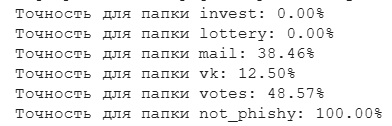



Классификация с моделью clip_base:

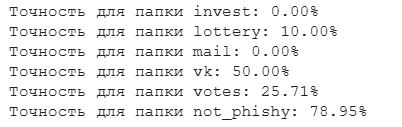